# VRP Demo with SCIP
This file is intended to build the model for the CVRP using SCIP

In [3]:
from pyscipopt import Model, Pricer, SCIP_RESULT, SCIP_STAGE
import networkx as nx
import random
import matplotlib.pyplot as plt

from cffi import FFI
ffi = FFI()
labelling_lib = ffi.dlopen("Labelling/labelling_lib.so")

funDefs = "void initGraph(unsigned num_nodes, unsigned* node_data, double* edge_data, const double capacity); void labelling(double const * dual,const bool farkas, unsigned* result);"
ffi.cdef(funDefs, override=True)

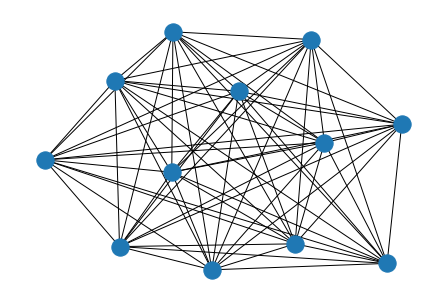

In [9]:
# Create Graph
G = nx.complete_graph(12)
for (u, v) in G.edges():
    G.edges[u,v]['weight'] = random.randint(1,10)
    
for node in G.nodes():
    G.nodes()[node]['demand'] = random.randint(1,10)

nx.draw(G)

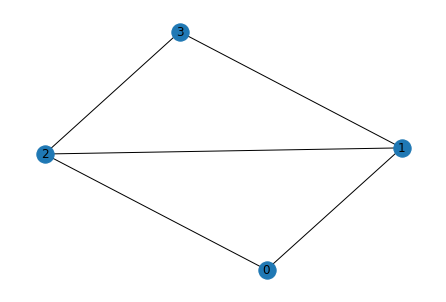

In [5]:
# Create Simple Graph for correctnes
G = nx.complete_graph(4)
G.remove_edge(0,3)
for (u, v) in G.edges():
    G.edges[u,v]['weight'] = 1
G.edges[1,2]['weight'] = 3

for node in G.nodes():
    G.nodes()[node]['demand'] = 1

nx.draw(G,with_labels=True)

In [6]:
class VRP(Model):
    def __init__(self,graph):
        super().__init__()
        
        self.original_graph = graph
        self.graph = graph.copy()
        self.vars = {}
        self.cons = []

In [7]:
class VRPPricer(Pricer): 
    def pricerinit(self):
        self.data['cons'] = [self.model.getTransformedCons(con) for con in self.model.cons]
        self.data['vars'] = {path:self.model.getTransformedVar(var) for (path,var) in self.model.vars.items()}
    
    def pricerfarkas(self):
#         print("Farkas Pricing has been called.")
        dual = [self.model.getDualfarkasLinear(con) for con in self.data['cons']]
        
        return self.labeling(dual, farkas=True)

    def pricerredcost(self):
        pi = [self.model.getDualsolLinear(con) for con in self.data['cons']]
        
        return self.labeling(pi)

    def labeling(self,dual,farkas=False):
        for path in nx.all_simple_paths(self.model.graph,0,list(G.nodes())[-1]):
            if tuple(path) not in self.data['vars'].keys():
                if farkas:
                    weight = 0
                else:
                    weight = nx.path_weight(self.model.graph,path,"weight")
                load = 0
                
                for node in path[1:-1]:
                    weight -= dual[node-1]
                    load += self.model.graph.nodes()[node]['demand']
                if weight < 0 and load <= self.data['capacity']:
                    var = self.model.addVar(vtype="B",obj=nx.path_weight(self.model.graph,path,"weight"),pricedVar=True)
                    for node in path[1:-1]:
                        self.model.addConsCoeff(self.data['cons'][node-1], var ,1)
                    
                    self.model.addConsCoeff(self.data['cons'][-1], var, 1)
                    self.data['vars'][tuple(path)] = var
#                     print(f"Found path {path} with negative reduced cost")
                    return {'result':SCIP_RESULT.SUCCESS}
        return {'result':SCIP_RESULT.SUCCESS}

In [ ]:
model = VRP(G)
num_vehicles = 3

# Create pricer
pricer = VRPPricer()
pricer.data = {}
pricer.data["capacity"] = 30
pricer.data["num_vehicles"] = num_vehicles
model.includePricer(pricer, "pricer","does pricing")

# Create a valid set of variables and the constraints to it
for i in range(1,G.number_of_nodes()-1):
    path = (0,i,G.number_of_nodes()-1)
    cost = nx.path_weight(G,path,"weight")
    var = model.addVar(vtype="B",obj=cost)
    model.vars[path] = var
    cons = model.addCons(var == 1, name=str(node),modifiable=True)
    model.cons.append(cons)
    
# Add the convexity constraint, which limits the number of available vehicles
convexity_constraint = model.addCons(sum(model.vars.values()) <= num_vehicles, modifiable=True)
model.cons.append(convexity_constraint)

# model.hideOutput()
model.optimize()
model.hideOutput(quiet=False)
model.printBestSol()
print(pricer.data['vars'])

presolving:
   (0.0s) probing cycle finished: starting next cycle
presolving (1 rounds: 1 fast, 1 medium, 1 exhaustive):
 0 deleted vars, 0 deleted constraints, 0 added constraints, 0 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 0 cliques
presolved problem has 10 variables (10 bin, 0 int, 0 impl, 0 cont) and 11 constraints
     11 constraints of type <linear>
Presolving Time: 0.00

 time | node  | left  |LP iter|LP it/n|mem/heur|mdpt |vars |cons |rows |cuts |sepa|confs|strbr|  dualbound   | primalbound  |  gap   | compl. 
  0.0s|     1 |     0 |    10 |     - |   634k |   0 |  11 |  11 |  11 |   0 |  0 |   0 |   0 |      --      |      --      |    Inf | unknown
 15.8s|     1 |     0 |    13 |     - |  1015k |   0 | 111 |  11 |  11 |   0 |  0 |   0 |   0 |      --      |      --      |    Inf | unknown
